### 입장객 데이터

In [238]:
import numpy as np
import pandas as pd
import os

# 모든 컬럼 출력 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# 데이터 파일 경로 및 이름 설정
base_path = r"C:\Users\전지현\Desktop\텀프\텀프\preprocessing\raw_data"
file_names_visitor = [
    "서울대공원 입장객 정보_2022년.xlsx",
    "서울대공원 입장객 정보_2023년.xlsx",
    "서울대공원 입장객 정보_2024년 12월.xlsx"
]

# 전체 데이터를 담을 리스트 초기화
df_list_visitor = []

# 각 연도별 Excel 파일 반복 처리
for file_name in file_names_visitor:
    file_path = os.path.join(base_path, file_name)
    xls = pd.ExcelFile(file_path)  # 여러 시트 포함된 엑셀 파일 읽기

    # 각 시트(한 달 단위) 순회
    for sheet in xls.sheet_names:
        try:
            # 5행(인덱스 4)을 컬럼명으로 사용, 7행(인덱스 6)부터 데이터
            df = pd.read_excel(xls, sheet_name=sheet, header=4)
            df = df.iloc[1:].copy()  # 앞 6행 제거 (0~5), 7행부터 데이터

            # 필요한 컬럼만 추출 ('날짜', '일합계')
            if '날짜' in df.columns and '일합계' in df.columns:
                df = df[['날짜', '일합계']]

                # 날짜, 수치형 데이터 변환
                df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')
                df['일합계'] = pd.to_numeric(df['일합계'], errors='coerce')

                # 컬럼명 영어로 변경
                df.columns = ['date', 'visitors_total']

                # 유효한 날짜만 필터링
                df = df.dropna(subset=['date'])

                # 리스트에 추가
                df_list_visitor.append(df)
        except Exception as e:
            print(f"[오류] 파일: {file_name}, 시트: {sheet}, 사유: {e}")

# 전체 시트 데이터 병합
df_visitor = pd.concat(df_list_visitor, ignore_index=True)

# 날짜 기준 정렬
df_visitor = df_visitor.sort_values('date').reset_index(drop=True)

In [239]:
# 시계열 파생 변수 생성
df_visitor['lag_1'] = df_visitor['visitors_total'].shift(1)
df_visitor['lag_7'] = df_visitor['visitors_total'].shift(7)
df_visitor['rolling_7'] = df_visitor['visitors_total'].rolling(window=7).mean()

# 날짜 기반 파생 변수 생성
df_visitor['day_of_week'] = df_visitor['date'].dt.dayofweek  # 0=월 ~ 6=일
df_visitor['month'] = df_visitor['date'].dt.month
df_visitor['year'] = df_visitor['date'].dt.year

# 파생 변수 생성 후 바로 이어서 실행
df_visitor = df_visitor.dropna(subset=['lag_1', 'lag_7', 'rolling_7']).reset_index(drop=True)

In [240]:
# 엑셀 파일로 저장
save_path = r"C:\Users\전지현\Desktop\텀프\텀프\preprocessing\processed_data\서울대공원_입장객.xlsx"
df_visitor.to_excel(save_path, index=False)

In [241]:
df_visitor

,date,visitors_total,lag_1,lag_7,rolling_7,day_of_week,month,year
0,2022-01-08,1431.0,463.0,1043.0,714.428571,5,1,2022
1,2022-01-09,1116.0,1431.0,1084.0,719.000000,6,1,2022
2,2022-01-10,367.0,1116.0,324.0,725.142857,0,1,2022
3,2022-01-11,249.0,367.0,417.0,701.142857,1,1,2022
4,2022-01-12,139.0,249.0,349.0,671.142857,2,1,2022
...,...,...,...,...,...,...,...,...
1084,2024-12-27,709.0,424.0,293.0,682.142857,4,12,2024
1085,2024-12-28,715.0,709.0,583.0,701.000000,5,12,2024
1086,2024-12-29,1156.0,715.0,599.0,780.571429,6,12,2024
1087,2024-12-30,19266.0,1156.0,360.0,3481.428571,0,12,2024


In [242]:
nan_rows = df_visitor[df_visitor.isna().any(axis=1)]
print(nan_rows)


Empty DataFrame
Columns: [date, visitors_total, lag_1, lag_7, rolling_7, day_of_week, month, year]
Index: []


### 날씨 데이터

In [243]:
# 파일 경로 목록 정의
file_names_weather = ["weather_2022.xls", "weather_2023.xls", "weather_2024.xls"]

# 연도별 파일을 읽어서 하나의 리스트에 저장
df_list_weather = []
for file in file_names_weather:
    file_path = os.path.join(base_path, file)
    df_year = pd.read_csv(file_path, sep='\t', encoding='cp949')
    df_list_weather.append(df_year)

# DataFrame 하나로 병합
df_weather = pd.concat(df_list_weather, ignore_index=True)

# 결과 확인
df_weather

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),1시간 최다 강수량 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),최대 풍속(m/s),최대 풍속 풍향(16방위),최대 풍속 시각(hhmi),평균 풍속(m/s),풍정합(100m),최다풍향(16방위),평균 이슬점온도(°C),최소 상대습도(%),최소 상대습도 시각(hhmi),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조시간(hr),1시간 최다일사 시각(hhmi),1시간 최다일사량(MJ/m2),합계 일사량(MJ/m2),일 최심신적설(cm),일 최심신적설 시각(hhmi),일 최심적설(cm),일 최심적설 시각(hhmi),합계 3시간 신적설(cm),평균 전운량(1/10),평균 중하층운량(1/10),평균 지면온도(°C),최저 초상온도(°C),평균 5cm 지중온도(°C),평균 10cm 지중온도(°C),평균 20cm 지중온도(°C),평균 30cm 지중온도(°C),0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),기사,안개 계속시간(hr)
0,108,서울,2022-01-01,-4.3,-10.2,710.0,2.3,1544,NaN,NaN,NaN,NaN,NaN,NaN,4.5,70.0,923.0,2.8,20.0,819.0,1.5,1335.0,50.0,-14.4,31.0,1329,46.3,2.1,1019.8,1034.0,247,1027.3,2351,1030.9,9.6,9.0,1200.0,1.82,10.39,NaN,NaN,NaN,NaN,NaN,1.4,1.4,-3.7,-15.4,-0.9,-1.0,-0.3,0.9,2.7,6.6,10.1,15.1,17.2,1.3,1.8,0.3,NaN,NaN
1,108,서울,2022-01-02,-1.3,-5.2,2356.0,3.0,1551,4.17,NaN,NaN,NaN,NaN,0.3,8.1,290.0,1345.0,4.6,290.0,1349.0,2.3,1996.0,50.0,-8.8,39.0,1754,57.9,3.3,1015.7,1028.4,2222,1024.4,502,1026.7,9.6,5.4,1200.0,1.71,8.52,0.5,655.0,0.5,655.0,0.5,4.1,4.0,-0.9,-10.7,-0.1,-0.5,-0.3,0.8,2.7,6.4,10.0,15.0,17.2,1.1,1.6,NaN,{눈}0305-{눈}{강도0}0600-0715. {연무}0550-{연무}{강도0}0...,NaN
2,108,서울,2022-01-03,-1.9,-8.0,714.0,2.5,1542,4.00,NaN,NaN,NaN,NaN,0.0,6.9,270.0,1319.0,4.1,250.0,1322.0,1.8,1555.0,270.0,-9.3,35.0,1152,58.3,3.2,1015.3,1028.5,913,1024.2,2230,1026.2,9.7,7.8,1200.0,1.75,9.35,NaN,NaN,NaN,NaN,NaN,4.9,3.6,-2.3,-14.4,-0.5,-0.8,-0.3,0.8,2.5,6.2,9.8,14.9,17.2,1.1,1.6,0.0,{눈}1815-2055. {눈}2240-{눈}{강도0}2400-,NaN
3,108,서울,2022-01-04,-2.5,-5.6,2400.0,1.0,1445,0.92,NaN,NaN,NaN,NaN,0.0,6.8,270.0,1444.0,4.2,250.0,1507.0,2.4,2048.0,290.0,-11.8,28.0,1606,51.8,2.6,1017.3,1029.8,2335,1024.5,2,1028.3,9.7,9.0,1200.0,1.94,11.30,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-1.8,-13.1,-0.1,-0.5,-0.3,0.7,2.5,6.1,9.7,14.8,17.1,1.4,2.0,NaN,-{눈}-0055.,NaN
4,108,서울,2022-01-05,-2.8,-7.8,634.0,1.9,1518,NaN,NaN,NaN,NaN,NaN,NaN,4.2,50.0,843.0,2.9,50.0,1314.0,1.7,1510.0,50.0,-12.5,34.0,1402,47.6,2.4,1016.9,1029.7,1,1025.9,1539,1028.0,9.7,1.9,1100.0,1.03,6.12,NaN,NaN,NaN,NaN,NaN,7.3,1.0,-2.8,-14.1,-0.5,-0.8,-0.4,0.7,2.4,5.9,9.5,14.7,17.1,1.0,1.4,NaN,{햇무리}0945-1535.,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,108,서울,2024-12-27,-2.6,-5.9,736.0,1.8,1403,2.00,NaN,NaN,NaN,NaN,0.0,10.4,290.0,2227.0,5.8,320.0,2221.0,2.7,2309.0,270.0,-11.4,35.0,1327,51.4,2.6,1014.8,1028.7,756,1023.2,1643,1025.8,9.6,7.3,1100.0,1.78,9.29,NaN,NaN,NaN,NaN,NaN,2.3,2.0,-2.7,-12.2,-0.2,-0.4,1.0,2.0,3.7,7.5,10.7,17.3,18.2,1.3,1.8,0.0,{눈}2020-{눈}{강도0}2100-2220.,NaN
1092,108,서울,2024-12-28,-3.0,-6.7,821.0,1.1,1508,NaN,NaN,NaN,NaN,NaN,NaN,9.9,290.0,1333.0,5.8,290.0,1338.0,2.5,2118.0,270.0,-12.5,37.0,1411,48.3,2.4,1013.1,1025.7,953,1022.6,1505,1024.1,9.6,8.3,1200.0,1.96,11.01,NaN,NaN,NaN,NaN,NaN,1.1,1.1,-3.3,-12.0,-0.5,-0.6,0.9,1.9,3.6,7.4,10.5,17.2,18.2,1.3,1.9,NaN,NaN,NaN
1093,108,서울,2024-12-29,1.1,-4.2,808.0,6.1,1417,NaN,NaN,NaN,NaN,NaN,NaN,5.0,180.0,1248.0,2.8,250.0,1307.0,1.5,1318.0,270.0,-6.9,35.0,1256,56.1,3.7,1013.5,1027.0,1017,1021.6,2338,1024.3,9.6,6.5,1200.0,1.90,9.49,NaN,NaN,NaN,NaN,NaN,5.1,4.8,-1.0,-11.6,-0.5,-0.6,0.7,1.7,3.5,7.2,10.4,17.0,18.2,1.3,1.8,NaN,NaN,NaN
1094,108,서울,2024-12-30,5.5,1.9,26.0,10.1,1234,0.25,NaN,NaN,NaN,NaN,0.0,12.0,230.0,1408.0,6.9,230.0,1423.0,2.3,2019.0,50.0,0.1,52.0,1402,68.5,6.2,1007.3,1021.6,1,1015.7,1941,1017.9,9.6,2.6,1200.0,1.58,6.29,NaN,NaN,NaN,NaN,NaN,7.4,6.5,0.7,-4.2,-0.1,-0.3,0.7,1.7,3.4,7.1,10.3,16.9,18.1,1.4,2.0,0.0,{연무}2140-2355. {비}2345-{비}{강도0}2400- {박무}2350-...,NaN


In [244]:
df_weather.describe()

,지점,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),10분 최다강수량 시각(hhmi),1시간 최다강수량(mm),1시간 최다 강수량 시각(hhmi),일강수량(mm),최대 순간 풍속(m/s),최대 순간 풍속 풍향(16방위),최대 순간풍속 시각(hhmi),최대 풍속(m/s),최대 풍속 풍향(16방위),최대 풍속 시각(hhmi),평균 풍속(m/s),풍정합(100m),최다풍향(16방위),평균 이슬점온도(°C),최소 상대습도(%),최소 상대습도 시각(hhmi),평균 상대습도(%),평균 증기압(hPa),평균 현지기압(hPa),최고 해면기압(hPa),최고 해면기압 시각(hhmi),최저 해면기압(hPa),최저 해면기압 시각(hhmi),평균 해면기압(hPa),가조시간(hr),합계 일조시간(hr),1시간 최다일사 시각(hhmi),1시간 최다일사량(MJ/m2),합계 일사량(MJ/m2),일 최심신적설(cm),일 최심신적설 시각(hhmi),일 최심적설(cm),일 최심적설 시각(hhmi),합계 3시간 신적설(cm),평균 전운량(1/10),평균 중하층운량(1/10),평균 지면온도(°C),최저 초상온도(°C),평균 5cm 지중온도(°C),평균 10cm 지중온도(°C),평균 20cm 지중온도(°C),평균 30cm 지중온도(°C),0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),안개 계속시간(hr)
count,1096.0,1096.000000,1095.000000,1095.000000,1096.000000,1096.000000,456.000000,291.000000,193.000000,291.000000,199.000000,455.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1091.000000,1091.000000,1092.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1095.000000,1091.000000,1091.000000,1091.000000,1091.000000,41.000000,41.000000,75.000000,75.000000,41.000000,1096.000000,1096.000000,1096.000000,1095.000000,1096.000000,1096.000000,1096.000000,1096.000000,1089.000000,1089.000000,1089.000000,1090.000000,1090.000000,1074.000000,1074.000000,455.000000,12.000000
mean,108.0,14.094252,10.084384,936.299543,18.806569,1370.335766,6.322566,2.536426,1106.849741,5.650515,940.653266,10.297802,8.387088,212.664652,1386.673077,4.703571,213.608059,1388.869963,2.316132,3165.711274,169.221612,7.190055,45.875000,1360.835766,65.683303,13.163047,1005.671989,1018.417245,1148.478102,1013.440785,1282.648723,1015.891150,12.202192,6.215490,1204.307974,2.252099,14.434005,2.817073,1282.073171,3.230667,699.266667,2.975610,4.784033,3.190146,15.456569,5.504840,14.653558,14.559672,14.331387,14.630839,15.551791,15.648852,16.552433,16.368807,16.491927,2.775791,3.962663,10.296923,2.689167
std,0.0,10.700465,10.979177,733.166354,10.647397,391.670149,6.295859,3.988325,808.664983,9.077625,1052.932042,21.831671,2.640999,93.667573,522.121401,1.246773,92.924697,522.740255,0.658241,16026.218239,105.303187,11.814964,16.533629,433.860787,13.926190,9.126611,7.921346,8.405854,919.711914,8.366554,740.543959,8.346318,1.788414,4.017392,124.258360,0.905532,7.433712,3.728532,735.963633,4.613083,841.177141,4.267598,3.104116,2.694871,11.543404,12.261941,10.300596,10.388772,9.924499,9.570573,9.198836,7.807604,6.758720,4.094781,2.079854,1.630582,2.328524,22.430492,2.794701
min,108.0,-14.700000,-17.300000,1.000000,-8.600000,1.000000,0.000000,0.000000,-2356.000000,0.000000,-2349.000000,0.000000,3.500000,20.000000,1.000000,2.400000,20.000000,2.000000,1.100000,978.000000,20.000000,-22.500000,13.000000,1.000000,22.900000,1.000000,985.100000,998.400000,1.000000,990.900000,1.000000,994.700000,9.500000,0.000000,800.000000,0.140000,0.300000,0.100000,100.000000,0.100000,1.000000,0.100000,0.000000,0.000000,-7.200000,-19.400000,-2.200000,-2.300000,-1.500000,-0.300000,1.200000,3.300000,6.000000,10.000000,13.200000,0.200000,0.300000,0.000000,0.170000
25%,108.0,4.800000,0.700000,536.000000,9.375000,1357.000000,1.500000,0.000000,431.000000,0.000000,358.500000,0.000000,6.500000,160.000000,1216.000000,3.800000,180.000000,1208.750000,1.800000,1584.500000,50.000000,-2.400000,33.000000,1315.750000,55.375000,5.300000,999.400000,1011.475000,215.000000,1006.975000,508.750000,1009.100000,10.500000,2.400000,1100.000000,1.725000,9.115000,0.600000,750.000000,0.800000,1.000000,0.600000,2.075000,0.600000,3.900000,-5.100000,4.100000,4.150000,4.500000,5.000000,6.600000,7.900000,9.900000,12.400000,14.600000,1.400000,2.000000,0.000000,0.815000
50%,108.0,15.700000,11.100000,634.000000,21.150000,1455.500000,4.000000,0.700000,1155.000000,1.400000,1050.000000,1.200000,8.000000,250.000000,1449.000000,4.500000,250.00

In [245]:
# 기존 DataFrame에서 원하는 컬럼만 선택하여 새로운 DataFrame 생성
df_weather_selected = df_weather[[
    "일시",
    "최저기온(°C)",
    "최고기온(°C)",
    "일강수량(mm)",
    "일 최심적설(cm)",
    "최대 풍속(m/s)",
    "평균 상대습도(%)"
]].copy()

# 컬럼명 변경
df_weather_selected.columns = [
    "date",
    "tmin",      # 최저기온
    "tmax",      # 최고기온
    "rain",      # 일 강수량
    "snow",      # 일 최심적설
    "wind",      # 최대 풍속
    "humidity"   # 평균 상대습도
]

# NaN인 값을 0으로 대체
df_weather_selected["rain"] = df_weather_selected["rain"].fillna(0)
df_weather_selected["snow"] = df_weather_selected["snow"].fillna(0)

df_weather_selected


,date,tmin,tmax,rain,snow,wind,humidity
0,2022-01-01,-10.2,2.3,0.0,0.0,2.8,46.3
1,2022-01-02,-5.2,3.0,0.3,0.5,4.6,57.9
2,2022-01-03,-8.0,2.5,0.0,0.0,4.1,58.3
3,2022-01-04,-5.6,1.0,0.0,0.0,4.2,51.8
4,2022-01-05,-7.8,1.9,0.0,0.0,2.9,47.6
...,...,...,...,...,...,...,...
1091,2024-12-27,-5.9,1.8,0.0,0.0,5.8,51.4
1092,2024-12-28,-6.7,1.1,0.0,0.0,5.8,48.3
1093,2024-12-29,-4.2,6.1,0.0,0.0,2.8,56.1
1094,2024-12-30,1.9,10.1,0.0,0.0,6.9,68.5


In [246]:
# NaN이 하나라도 있는 행만 필터링
nan_rows = df_weather_selected[df_weather_selected.isna().any(axis=1)]

# 결과 출력
print(nan_rows)

# tmin이 NaN이면 25.2로 채우기
df_weather_selected["tmin"] = df_weather_selected["tmin"].fillna(25.2)

# wind가 NaN이면 바로 이전 날의 값으로 채우기 (ffill: forward fill)
df_weather_selected["wind"] = df_weather_selected["wind"].fillna(method='ffill')

           date  tmin  tmax   rain  snow  wind  humidity
219  2022-08-08   NaN  28.4  129.6   0.0   8.6      91.6
708  2023-12-10   6.7  15.5    0.0   0.0   NaN      67.9
709  2023-12-11   5.0  12.3   11.4   0.0   NaN      82.9
800  2024-03-11   2.0  10.8    0.0   0.0   NaN      62.3
801  2024-03-12   4.4  10.0    2.1   0.0   NaN      78.0


C:\Users\전지현\AppData\Local\Temp\ipykernel_14324\1892483561.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_weather_selected["wind"] = df_weather_selected["wind"].fillna(method='ffill')


In [247]:
# NaN이 하나라도 있는 행만 필터링
nan_rows = df_weather_selected[df_weather_selected.isna().any(axis=1)]

# 결과 출력
print(nan_rows)

Empty DataFrame
Columns: [date, tmin, tmax, rain, snow, wind, humidity]
Index: []


In [248]:
df_weather_selected

,date,tmin,tmax,rain,snow,wind,humidity
0,2022-01-01,-10.2,2.3,0.0,0.0,2.8,46.3
1,2022-01-02,-5.2,3.0,0.3,0.5,4.6,57.9
2,2022-01-03,-8.0,2.5,0.0,0.0,4.1,58.3
3,2022-01-04,-5.6,1.0,0.0,0.0,4.2,51.8
4,2022-01-05,-7.8,1.9,0.0,0.0,2.9,47.6
...,...,...,...,...,...,...,...
1091,2024-12-27,-5.9,1.8,0.0,0.0,5.8,51.4
1092,2024-12-28,-6.7,1.1,0.0,0.0,5.8,48.3
1093,2024-12-29,-4.2,6.1,0.0,0.0,2.8,56.1
1094,2024-12-30,1.9,10.1,0.0,0.0,6.9,68.5


In [249]:
# 저장 경로 및 파일명 설정
output_path = r"C:\Users\전지현\Desktop\텀프\텀프\preprocessing\processed_data\날씨.xlsx"

# DataFrame을 엑셀 파일로 저장
df_weather_selected.to_excel(output_path, index=False)

### 미세먼지

In [250]:
# 파일 경로 설정
file_path = r"C:\Users\전지현\Desktop\텀프\텀프\preprocessing\raw_data\미세먼지.xls"

# 파일 읽기
df_air = pd.read_csv(file_path, sep='\t', encoding='cp949')

# 모든 컬럼 보기 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# 데이터 확인
df_air


,지점,지점명,일시,일 미세먼지 농도(㎍/㎥)
0,116,관악산,2022-01-02,34
1,116,관악산,2022-01-04,32
2,116,관악산,2022-01-05,30
3,116,관악산,2022-01-06,50
4,116,관악산,2022-01-07,60
...,...,...,...,...
842,116,관악산,2024-12-27,28
843,116,관악산,2024-12-28,28
844,116,관악산,2024-12-29,23
845,116,관악산,2024-12-30,49


In [251]:
df_air.describe()

,지점,일 미세먼지 농도(㎍/㎥)
count,847.0,847.000000
mean,116.0,35.563164
std,0.0,23.632289
min,116.0,6.000000
25%,116.0,23.000000
50%,116.0,31.000000
75%,116.0,40.000000
max,116.0,295.000000


In [252]:
# 필요한 두 컬럼만 추출
df_air_selected = df_air[['일시', '일 미세먼지 농도(㎍/㎥)']].copy()

# 컬럼명 변경
df_air_selected.columns = ['date', 'air']

# 결과 확인
df_air_selected

,date,air
0,2022-01-02,34
1,2022-01-04,32
2,2022-01-05,30
3,2022-01-06,50
4,2022-01-07,60
...,...,...
842,2024-12-27,28
843,2024-12-28,28
844,2024-12-29,23
845,2024-12-30,49


In [253]:
nan_rows = df_air_selected[df_air_selected.isna().any(axis=1)]
print(nan_rows)

Empty DataFrame
Columns: [date, air]
Index: []


In [254]:
# 저장 경로 설정
output_path = r"C:\Users\전지현\Desktop\텀프\텀프\preprocessing\processed_data\미세먼지.xlsx"

# 엑셀 파일로 저장
df_air_selected.to_excel(output_path, index=False)

### 방학기간

In [255]:
df_vacation = pd.DataFrame({'date': pd.date_range(start='2022-01-01', end='2024-12-31')})

# 방학 기간 리스트
vacation_periods = [
    ('2022-01-08', '2022-03-02'),
    ('2022-07-22', '2022-08-19'),
    ('2022-01-09', '2022-03-02'),
    ('2022-07-25', '2022-08-10'),
    ('2024-01-10', '2024-03-04'),
    ('2024-07-26', '2024-08-21'),
]

# 문자열을 datetime으로 변환
vacation_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in vacation_periods]

# vacation 컬럼 초기화
df_vacation['vacation'] = 0

# 방학 기간에 해당하면 1로 설정
for start, end in vacation_periods:
    df_vacation.loc[(df_vacation['date'] >= start) & (df_vacation['date'] <= end), 'vacation'] = 1

df_vacation

,date,vacation
0,2022-01-01,0
1,2022-01-02,0
2,2022-01-03,0
3,2022-01-04,0
4,2022-01-05,0
...,...,...
1091,2024-12-27,0
1092,2024-12-28,0
1093,2024-12-29,0
1094,2024-12-30,0


In [256]:
# 저장 경로 설정
output_path = r"C:\Users\전지현\Desktop\텀프\텀프\preprocessing\processed_data\방학.xlsx"

# 엑셀 파일로 저장
df_vacation.to_excel(output_path, index=False)

### 주말

In [257]:
df_weekend = pd.DataFrame({'date': pd.date_range(start='2022-01-01', end='2024-12-31')})
df_weekend['weekend'] = df_weekend['date'].dt.weekday.isin([5, 6]).astype(int)

df_weekend

,date,weekend
0,2022-01-01,1
1,2022-01-02,1
2,2022-01-03,0
3,2022-01-04,0
4,2022-01-05,0
...,...,...
1091,2024-12-27,0
1092,2024-12-28,1
1093,2024-12-29,1
1094,2024-12-30,0


In [258]:
# 저장 경로 설정
output_path = r"C:\Users\전지현\Desktop\텀프\텀프\preprocessing\processed_data\주말.xlsx"

# 엑셀 파일로 저장
df_weekend.to_excel(output_path, index=False)

### dataframe 통합

In [259]:
# 폴더 경로 설정
base_path = r"C:\Users\전지현\Desktop\텀프\텀프\preprocessing\processed_data"

# 파일명 목록
file_list = [
    "날씨.xlsx",
    "미세먼지.xlsx",
    "서울대공원_입장객.xlsx",
    "방학.xlsx",
    "주말.xlsx"
]

# 파일 읽고 'date' 컬럼을 datetime으로 변환한 뒤 리스트에 저장
dfs = []
for file_name in file_list:
    path = os.path.join(base_path, file_name)
    df = pd.read_excel(path)
    df['date'] = pd.to_datetime(df['date'])  # 날짜 형식 변환
    dfs.append(df)

# 순차적으로 date 기준 outer 병합
df_merged = dfs[0]
for next_df in dfs[1:]:
    df_merged = pd.merge(df_merged, next_df, on='date', how='outer')

# 정렬 및 인덱스 재설정
df_merged = df_merged.sort_values('date').reset_index(drop=True)

In [260]:
df_merged

,date,tmin,tmax,rain,snow,wind,humidity,air,visitors_total,lag_1,lag_7,rolling_7,day_of_week,month,year,vacation,weekend
0,2022-01-01,-10.2,2.3,0.0,0.0,2.8,46.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,2022-01-02,-5.2,3.0,0.3,0.5,4.6,57.9,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,2022-01-03,-8.0,2.5,0.0,0.0,4.1,58.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,2022-01-04,-5.6,1.0,0.0,0.0,4.2,51.8,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,2022-01-05,-7.8,1.9,0.0,0.0,2.9,47.6,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2024-12-27,-5.9,1.8,0.0,0.0,5.8,51.4,28.0,709.0,424.0,293.0,682.142857,4.0,12.0,2024.0,0,0
1092,2024-12-28,-6.7,1.1,0.0,0.0,5.8,48.3,28.0,715.0,709.0,583.0,701.000000,5.0,12.0,2024.0,0,1
1093,2024-12-29,-4.2,6.1,0.0,0.0,2.8,56.1,23.0,1156.0,715.0,599.0,780.571429,6.0,12.0,2024.0,0,1
1094,2024-12-30,1.9,10.1,0.0,0.0,6.9,68.5,49.0,19266.0,1156.0,360.0,3481.428571,0.0,12.0,2024.0,0,0


In [261]:
# air 컬럼의 NaN을 다음 행의 값으로 채우기 (backward fill)
df_merged['air'] = df_merged['air'].fillna(method='bfill')

C:\Users\전지현\AppData\Local\Temp\ipykernel_14324\103672700.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged['air'] = df_merged['air'].fillna(method='bfill')


In [262]:
nan_rows = df_merged[df_merged.isna().any(axis=1)]
print(nan_rows)
df_merged = df_merged.dropna()  # 결측 제거


        date  tmin  tmax  rain  snow  wind  humidity   air  visitors_total  \
0 2022-01-01 -10.2   2.3   0.0   0.0   2.8      46.3  34.0             NaN   
1 2022-01-02  -5.2   3.0   0.3   0.5   4.6      57.9  34.0             NaN   
2 2022-01-03  -8.0   2.5   0.0   0.0   4.1      58.3  32.0             NaN   
3 2022-01-04  -5.6   1.0   0.0   0.0   4.2      51.8  32.0             NaN   
4 2022-01-05  -7.8   1.9   0.0   0.0   2.9      47.6  30.0             NaN   
5 2022-01-06  -5.9   3.3   0.0   0.0   4.6      47.1  50.0             NaN   
6 2022-01-07  -5.9   4.5   0.0   0.0   3.0      47.1  60.0             NaN   

   lag_1  lag_7  rolling_7  day_of_week  month  year  vacation  weekend  
0    NaN    NaN        NaN          NaN    NaN   NaN         0        1  
1    NaN    NaN        NaN          NaN    NaN   NaN         0        1  
2    NaN    NaN        NaN          NaN    NaN   NaN         0        0  
3    NaN    NaN        NaN          NaN    NaN   NaN         0        0  
4    

In [263]:
# 결과 저장
output_path = os.path.join(base_path, "서울대공원_날씨_미세먼지_입장객_병합.xlsx")
df_merged.to_excel(output_path, index=False)

In [264]:
df_merged

,date,tmin,tmax,rain,snow,wind,humidity,air,visitors_total,lag_1,lag_7,rolling_7,day_of_week,month,year,vacation,weekend
7,2022-01-08,-5.0,3.7,0.0,0.0,3.5,64.3,44.0,1431.0,463.0,1043.0,714.428571,5.0,1.0,2022.0,1,1
8,2022-01-09,-1.2,5.6,0.0,0.0,2.8,71.5,121.0,1116.0,1431.0,1084.0,719.000000,6.0,1.0,2022.0,1,1
9,2022-01-10,-3.4,4.4,0.9,0.9,3.4,68.3,74.0,367.0,1116.0,324.0,725.142857,0.0,1.0,2022.0,1,0
10,2022-01-11,-10.3,0.3,0.2,1.0,7.2,55.5,43.0,249.0,367.0,417.0,701.142857,1.0,1.0,2022.0,1,0
11,2022-01-12,-11.3,-3.4,0.0,0.2,4.2,47.8,31.0,139.0,249.0,349.0,671.142857,2.0,1.0,2022.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2024-12-27,-5.9,1.8,0.0,0.0,5.8,51.4,28.0,709.0,424.0,293.0,682.142857,4.0,12.0,2024.0,0,0
1092,2024-12-28,-6.7,1.1,0.0,0.0,5.8,48.3,28.0,715.0,709.0,583.0,701.000000,5.0,12.0,2024.0,0,1
1093,2024-12-29,-4.2,6.1,0.0,0.0,2.8,56.1,23.0,1156.0,715.0,599.0,780.571429,6.0,12.0,2024.0,0,1
1094,2024-12-30,1.9,10.1,0.0,0.0,6.9,68.5,49.0,19266.0,1156.0,360.0,3481.428571,0.0,12.0,2024.0,0,0


### EDA

In [265]:
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우용
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'  # 맥용
else:
    plt.rcParams['font.family'] = 'NanumGothic'  # 리눅스용

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

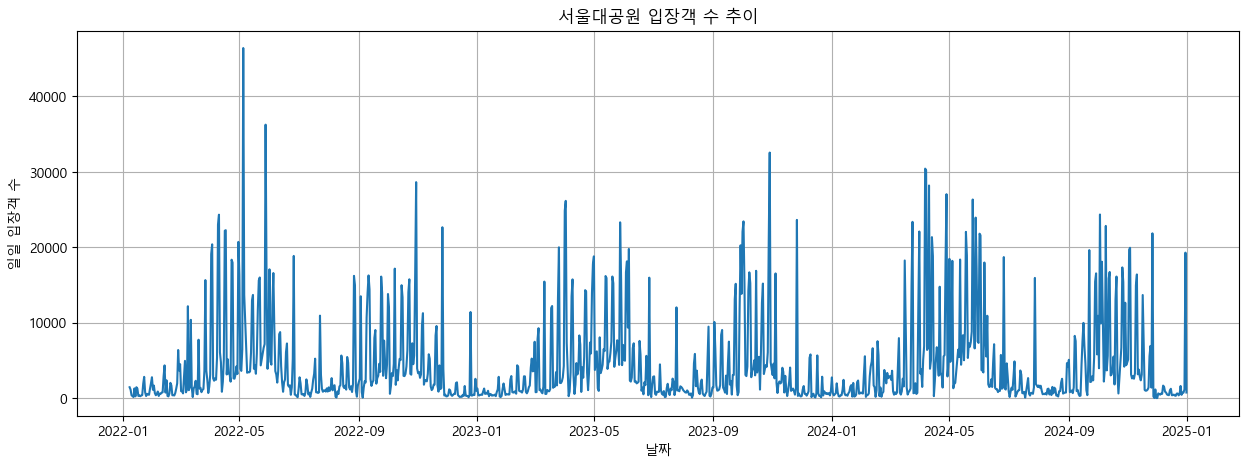

In [266]:
plt.figure(figsize=(15, 5))
plt.plot(df_visitor['date'], df_visitor['visitors_total'])
plt.title('서울대공원 입장객 수 추이')
plt.xlabel('날짜')
plt.ylabel('일일 입장객 수')
plt.grid(True)
plt.show()


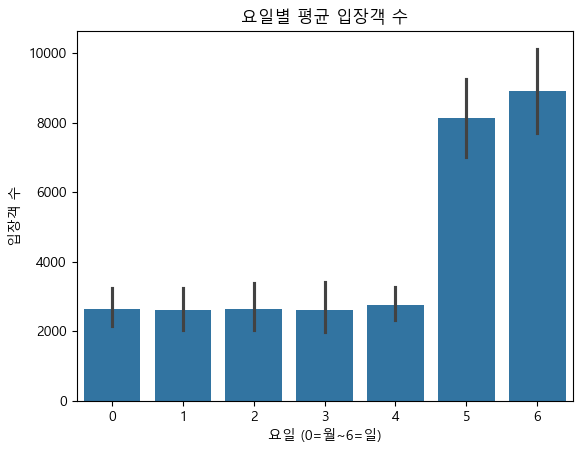

In [268]:
df_visitor['day_of_week'] = df_visitor['date'].dt.dayofweek  # 0=월~6=일
sns.barplot(x='day_of_week', y='visitors_total', data=df_visitor)
plt.title('요일별 평균 입장객 수')
plt.xlabel('요일 (0=월~6=일)')
plt.ylabel('입장객 수')
plt.show()


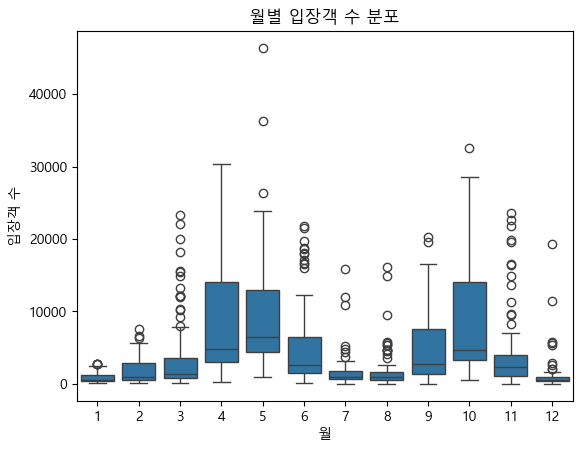

In [269]:
df_visitor['month'] = df_visitor['date'].dt.month
sns.boxplot(x='month', y='visitors_total', data=df_visitor)
plt.title('월별 입장객 수 분포')
plt.xlabel('월')
plt.ylabel('입장객 수')
plt.show()


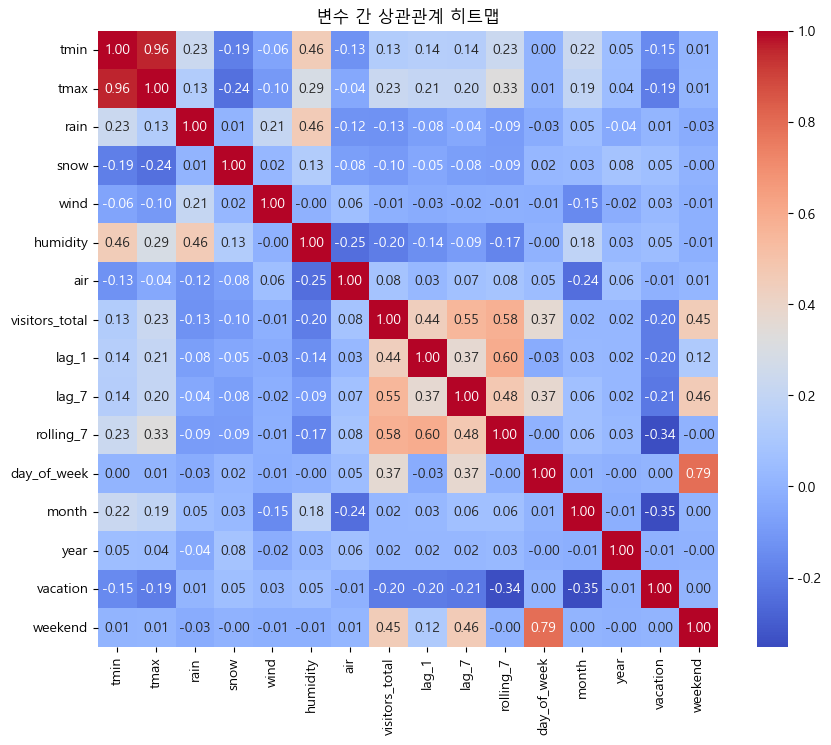

In [270]:
numeric_cols = ['tmin', 'tmax',	'rain', 'snow', 'wind', 'humidity', 'air', 'visitors_total', 'lag_1', 'lag_7', 'rolling_7', 'day_of_week', 'month', 'year', 'vacation', 'weekend']
corr = df_merged[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('변수 간 상관관계 히트맵')
plt.show()

In [271]:

# 상관계수 계산
corr_matrix = df_merged.corr()

# 절댓값 기준으로 0.7 이상인 쌍 추출 (자기 자신 제외, 중복 제외)
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # 상삼각행렬만
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['변수1', '변수2', '상관계수']
high_corr_pairs = high_corr_pairs[high_corr_pairs['상관계수'].abs() >= 0.7]

# 결과 출력
print(high_corr_pairs)

             변수1      변수2      상관계수
13          date     year  0.942788
16          tmin     tmax  0.958668
129  day_of_week  weekend  0.791187
